Материалы занятия взяты из курса Никиты Котлярова

## Обязательные баллы

За это дз надо набрать 30 баллов. Все баллы выше этой планки - дополнительные 

In [1]:
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.datasets import make_classification, make_blobs, make_circles, make_moons, load_digits
from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

### Задача
В этой работе вам необходимо будет обучать модели машинного обучения, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

Датасет - https://drive.google.com/file/d/1EyhatnsqrOuPPcreH8Pbz-eDpSJDHkqz/view?usp=sharing

Загрузите набор данных *data.adult.csv* с помощью `pandas`. Чтобы посмотреть данные, можно вызвать для загруженного `DataFrame` метод `head`.

**(2 балла)** Для некоторых объектов могут быть пропущены значения некоторых признаков. Пропуски могут обозначаться либо значением `numpy.nan`, либо каким-то определенным значением, которое указывается в описании к набору данных. В данном датасете пропущенные значения обозначены как "?". 

Некоторые алгоритмы могут работать некорректно с пропущенными значениями. Примените к выборке один из методов обработки пропущенных значений. Обоснуйте свой выбор.

Далее проделайте следующее:
 - Перемешайте объекты, чтобы исключить возможные последствия изначальной сортировки данных.
 - Выделите метки классов в отдельный вектор, удалите их из матрицы "объект-признак" и преобразуйте метки классов к бинарному формату (+1, -1).
 - Оставьте в датасете только вещественные признаки; сначала мы будем работать только с ними.
 
Более подробно о работе с пропусками в Pandas можно прочитать, например, [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

### Обучение классификаторов на вещественных признаках

**Важно!** Для оценки качества используйте метрику ROC-AUC.

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2
алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала оптимизируем один гиперпараметр у DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры пусть принимают значения по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). В качестве схемы кросс-валидации используйте 5-Fold CV: [KFoldCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold).

**(6 баллов)** Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (значение качества на каждом фолде, среднее значение качества и много другой полезной информации можно получить из поля [*cv results_*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)). Построение графика стоит выделить в отдельную функцию - это избавит вас от дублирования кода при выполнении дальнейшего задания.

Что вы можете сказать о получившихся графиках?

**(3 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. В общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите значение гиперпараметра, на которой ощутимый прирост качества перестает наблюдаться. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

**(2 балла)** Качество алгоритмов может зависеть не только от значений гиперпараметров, но и от предобратки исходных признаков. Некоторые из рассматриваемых нами алгоритмов чувствительны к масштабу признаков. Посмотрим, насколько различны распределения признаков. Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*.

Глядя на получившиеся графики, скажите в чем заключается особенность данных? На какие алгоритмы это может повлиять? Почему?

Масштабирование признаков можно выполнить, например, одним из следующих способов:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(2 балла)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

Изменилось ли качество у алгоритмов и почему?

**(4 балла)** Теперь сделайте перебор гиперпараметров по сетке и найдите оптимальные комбинации для следующих моделей и гиперпараметров: 
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее), в качестве глубины деревьев возьмите ту, что подобрана для одиночного решающего дерева (или чуть большую)

Нарисуйте соответствующие графики.
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

Какой из алгоритмов имеет наилучшее качество?

(для оптимизации кода и вычислений перед выполнением прочитайте следующее задание)

**(3 балла)** Сравните алгоритмы с точки зрения времени обучения и предсказания. Какой из алгоритмов работает дольше всего и почему?

(hint: [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) подсчитывает не только качество на кросс-валидации, но и время работы алгоритмов)

### Добавление категориальных признаков в модели

Вспомним, что у нас еще есть категориальные признаки. Давайте посмотрим, как изменится качество модели после добавления этих признаков. 

**(1 балл)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры (хотя правильнее было бы это сделать). 

**(3 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score).

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

# Кластеризация 
В следующем блоке мы рассмотрим задачу кластеризации.

Для начала предлагается проанализировать поведение различных метрик. Сложно дать четкое определение, что такое хорошая кластеризация, однако можно сформулировать некоторые ее признаки:

объекты внутри кластера должны быть похожи друг на друга,
похожие объекты должны попадать в один кластер (этот пункт не следует из предыдущего!),
в случае, когда нам известны истинные метки классов, метрика не должна учитывать абсолютные значения меток объектов, полученных из кластеризации.
Вам предлагается сравнить 4 различных метрики:

Homogeneity, Completeness и V-measure
Adjusted Rand index
Для выполнения задания используйте датасет, составленный из рукописных "картинок" цифр.

In [2]:
digits, labels = sklearn_shuffle(*load_digits(return_X_y=True))

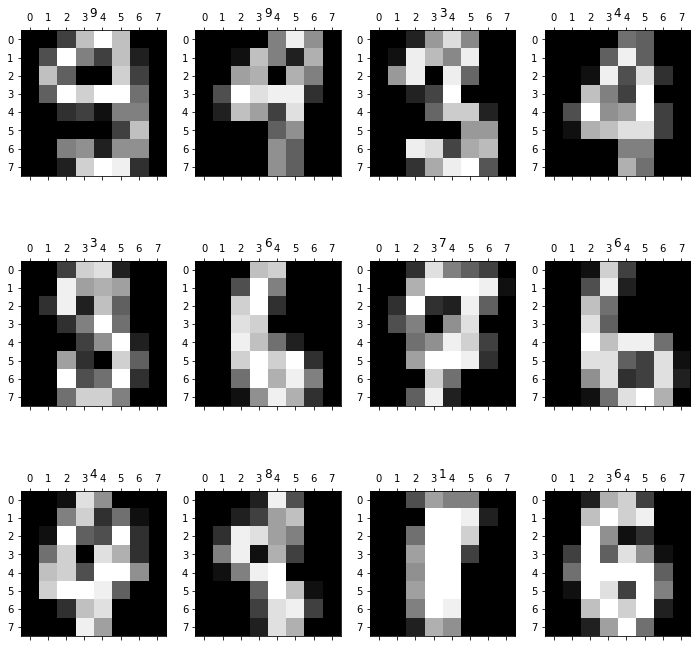

In [4]:

digits, labels = sklearn_shuffle(*load_digits(return_X_y=True))
# В labels собраны названия цифр, в digits - их векторное представление:

f, axarr = plt.subplots(3, 4, figsize=(12, 12))
plt.gray()
for ax, digit, label in zip(axarr.flatten(), digits, labels):
    ax.matshow(digit.reshape(8, 8))
    ax.tick_params(top='off', labeltop='off', left='off', labelleft='off', bottom='off')
    ax.set_title(label)



(**1 балл**) Кластеризуйте изображения при помощи алгоритма KMeans:

**3 балла**. Поcтройте графики зависимости значений метрик от числа кластеров (рекомендуется рассмотреть от 2 до 20 кластеров). Если графики получаются зашумленным, запустите алгоритм несколько раз из разных случайных положений центроидов и усредните результат.
Визуализируйте изображения, соответствующие центроидам лучшей кластеризации. Что представляют собой эти изображения?
Визуализируйте несколько изображений, которые были отнесены к неправильному кластеру в случае лучшей кластеризации. Как вы думаете, почему они были неправильно кластеризованы?

Наши данные имеют относительно высокую размерность - 64. Попробуем уменьшить размерность и попробовать другие алгоритмы кластеризации.

(**2 балла**) Для наглядности попробуем уложить наши данные в двухмерное пространство. Примените PCA, tSNE и UMAP к имеющися данным и визуалируйте полученный результат. Чем отличаются результаты этих двух подходов?



​

(**до 7 баллов**) К данным уменьшенной размерности примените алгоритмы кластеризации KMeans, DBSCAN, и AffinityPropagation. Подбор параметров - на ваше усмотрение. Для каких-то методов можно даже не делать перебор или ограничиться небольшой сеткой, главное - аргументировать, почему в этом случае это уместно. Метрику выберите на свою усмотрение, пояснив свой выбор.

Визуалируйте результат кластеризации (с лучшими параметрами) на каждом из способов уменьшения размерности.

Как вы считаете, помогло ли уменьшение размерности в данном датасете? Улучшено ли качество в сравнении с KMeans на полных данных? Сравните алгоритмы кластеризации: в чем преимущества и недостатки каждого из них?

# XGBoost и все-все-все

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

Работать вам предстоит с датасетом, составленным из рукописных "картинок" цифр. 
Он вам знаком по предыдущему заданию (можете брать код для работы с ним оттуда). Только в этот раз мы возьмем его полную версию - картинки будут размером 28х28 вместо 8х8, а общее число картинок - 42000 вместо 1797.

https://www.tensorflow.org/datasets/catalog/mnist

Загрузите датасет и разбейте его на выборки для обучения и контроля. Можете использовать приведенную выше ссылку, можете найти другие 


Для ускорения работы возьмите небольшую часть датасета, например, 3%. Отладьте на ней код, а потом запустите расчеты на больших данных.

Скорее всего, вычисления будут трудоемкими, если брать весь датасет, поэтому для итоговых вычислений можете взять только его часть 
(но не меньше 30%).

Обратите внимание, что наблюдаемые результаты могут сильно зависеть от того, делаете ли вы эксперимент на маленьких или больших данных.
Так, на выборке размера 100 ваш классификатор может легко переобучиться,
в то время как на выборке размера 10000 этот эффект может не наблюдаться. Поэтому делайте выводы после запуска расчетов на больших данных.


In [ ]:
def load_data():
    data = pd.read_csv('train.csv')
    data = data.sample(frac=SAMPLE_FRACTION)
    labels = data['label'].values
    digits = data.drop('label', 1).values
    return digits, labels

digits, labels = load_data()
X_train, X_test, y_train, y_test = train_test_split(digits, labels, test_size=0.25)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

(**3 балла**)
Давайте в качестве базового решения посмотрим на известные нам алгоритмы. Возьмите kNN и Random Forest. Обучите их (гиперпараметры оставьте по умолчанию), подсчитайте точность и logloss на тестовой выборке. Какой алгоритм дал лучший результат? Как различаются алгоритмы по качеству и времени обучения и предсказания?

Далее целевой метрикой для нас будет logloss. Точность также будем вычислять, как более интерпретируемую метрику.

## XGBoost


Установите библиотеку xgboost. Реализация бустинга есть и в sklearn, но в ней уделено сильно меньше внимания регуляризации
и скорости, поэтому мы будем использовать xgboost.

In [ ]:
import xgboost
from xgboost import XGBClassifier


(**1 балл**) Возьмите классификатор с настройками по умолчанию (рекомендуется установить n_jobs на -1 для ускорения расчета). 
Оцените его качество

In [ ]:
xgboost_classifier = XGBClassifier(n_jobs=-1)

Попробуем потюнить XGBoost.

(**1 балл**) Выберите относительно большую learning_rate (𝜂∈[0.05,0.3]), подберите оптимальное число деревьев для выбранного 𝜂. В методе fit задайте eval_metric, равное mlogloss, в eval_set передайте [(X_test, y_test)]; таким образом, вы сможете получать качество вашей классификации после каждого обученного базового классификатора. Вы можете регулировать "болтливость" метода обучения с помощью параметры verbose (например, задать его равным 10).

(**2 балла**)
Постройте график зависимости качества классификации от числа базовых классификаторов (для этого можете воспользоваться методом evals_result). Для большей наглядности можете отдельно отобразить график по последним 60 точкам. Как вам кажется, какое количество базовых классификаторов будет оптимальным?


(**3 балла**) Зафиксируйте выбранное количество деревьев. Настройте параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, colsample_bytree). Более подробно подробно про эти параметры вы можете почитать в документации, указанной выше. Не забывайте, что бустинг, как правило, хорошо работает на деревьях небольшой глубины.

Правильно подбирать эти параметры по сетке, но данный перебор был бы чересчур трудоемким. Поэтому подбирайте их последовательно.

Считать score на каждом шаге не нужно, сравнивайте только обученные классификаторы. Сохраняйте качество (accuracy и logloss) вашего классификатора после каждого настроенного параметра.

(**1 балл**) Далее таким же образом настройте регуляризацию (𝜆,𝛼).

(**1 балл**) После того, как все параметры настроены, уменьшите learning_rate, пропорционально увеличив число деревьев. Обучите итоговый классификатор.

(**3 балла**)
Постройте 2 графика:

по оси X отложены этапы настройки классификатора: по умолчанию, после выбора числа деревьев, после настройки каждого гиперпараметра, итоговый классификатор;
по оси Y на первом графике - roc-auc на каждом этапе, на втором - pr-auc.
Какой этап дал наиболее существенный прирост качества? Получилось ли у вас поднять качество выше, чем у базовых решений: kNN и Random Forest?